#Pre-proocess data

In [1]:
! pip install talib-binary
! gdown 17OYeD6dlfwX28FNoUpqXkLVpzjUtTCRW
! unzip /content/ThaiDepression.zip
! pip install -qqq greykite
! pip install --upgrade pandas
! python -m pip uninstall matplotlib
! pip install matplotlib==3.1.3
! pip install tsai
! pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 4.1 MB/s 
Downloading...
From: https://drive.google.com/uc?id=17OYeD6dlfwX28FNoUpqXkLVpzjUtTCRW
To: /content/ThaiDepression.zip
100% 8.78M/8.78M [00:00<00:00, 58.8MB/s]
Archive:  /content/ThaiDepression.zip
   creating: ThaiDepression/2016/
  inflating: ThaiDepression/2016/ahb-2016-10.csv  
  inflating: ThaiDepression/2016/ahb-2016-10.pdf  
  inflating: ThaiDepression/2016/ahb-2016-11.csv  
  inflating: ThaiDepression/2016/ahb-2016-11.pdf  
  inflating: ThaiDepression/2016/ahb-2016-12.csv  
  inflating: ThaiDepression/2016/ahb-2016-12.pdf  
   creating: ThaiDepression/2017/
  inflating: ThaiDepression/2017/ahb-2017-01.csv  
  inflating: ThaiDepression/2017/ahb-2017-01.pdf  
  inflating: ThaiDepression/2017/ahb-2017-02.csv  
  inflating: ThaiDepression/2017/ahb-2017-02.pdf  
  inflating: ThaiDepression/2017/ahb-2017-03.csv  
  inflating: ThaiD

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 241 kB 2.5 MB/s 
     |████████████████████████████████| 750.6 MB 10 kB/s 
     |████████████████████████████████| 2.5 MB 54.0 MB/s 
     |████████████████████████████████| 19.1 MB 706 kB/s 
     |████████████████████████████████| 19.1 MB 774 kB/s 
     |████████████████████████████████| 21.0 MB 86.9 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.1

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import talib
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster 
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results
import plotly
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import  plot_pacf
from statsmodels.tsa.stattools import pacf
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from tsai.all import *
from tsai.inference import load_learner
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from pmdarima import arima
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.utils.plotting import plot_series
import seaborn as sns

In [3]:
path = "/content/ThaiDepression/"
year_list = os.listdir(path)
year_list.sort()

df_list = []
name_list = []
 
for i in range(len(year_list)):
    file_list = os.listdir(path+year_list[i])
    file_list.sort()
    for f in file_list:
        if '.csv' in f:
            # print(f)
            name_list.append(f[4:11])
            df_list.append(pd.read_csv(path+year_list[i]+'/'+f, header=None, index_col=False))


finished_process = []
for i in range(len(df_list[0])):
    finished_process.append(pd.DataFrame(df_list[0].iloc[i,:]).T.reset_index(drop=True))
    finished_process[i]['y-m'] = name_list[0]


i=1
while(i != len(df_list)):
    # print('i=' + str(i))
    if len(df_list[i]) == 89:
        insert = { 0 : np.nan, 1 : np.nan, 2 : np.nan, 3 : np.nan, 4 : np.nan, 5 : np.nan, 6 :np.nan, 7 : np.nan, 8 : np.nan, 9 : np.nan, 'y-m' : name_list[i]}
        finished_process[89] = pd.concat([finished_process[89], pd.DataFrame(insert, index=[0])], ignore_index = True)
    for j in range(len(df_list[i])):
        # print('j=' + str(j))
        if len(df_list[i].columns) == 6 :
            insert = { 0 : df_list[i].iloc[j,0], 1 : df_list[i].iloc[j,1], 2 : np.nan, 3 : df_list[i].iloc[j,2], 4 : df_list[i].iloc[j,3], 5 : np.nan, 6 :np.nan, 7 : df_list[i].iloc[j,4], 8 : np.nan, 9 : df_list[i].iloc[j,5], 'y-m' : name_list[i]}
            finished_process[j] = pd.concat([finished_process[j], pd.DataFrame(insert, index=[0])], ignore_index = True)
        else:
            finished_process[j] = pd.concat([finished_process[j], pd.DataFrame(df_list[i].iloc[j,:]).T.reset_index(drop=True)], ignore_index = True)
            finished_process[j]['y-m'][i] = name_list[i]
    i=i+1


for i in range(len(finished_process)):
    finished_process[i].index = finished_process[i]['y-m'].values
    finished_process[i].drop(['y-m'], axis=1, inplace=True)
    # finished_process[i].index = pd.to_datetime(finished_process[i].index, format='%Y-%m')
    finished_process[i] = finished_process[i].replace(',','', regex=True)  
    finished_process[i] = finished_process[i].apply(pd.to_numeric)

    # pct_change(1) = (value on this index - value on previous index) / value on previous index

    finished_process[i]['0_pct_change'] = finished_process[i][0].pct_change(1)
    finished_process[i]['1_pct_change'] = finished_process[i][1].pct_change(1)
    finished_process[i]['2_pct_change'] = finished_process[i][2].pct_change(1)
    finished_process[i]['3_pct_change'] = finished_process[i][3].pct_change(1)
    finished_process[i]['4_pct_change'] = finished_process[i][4].pct_change(1)
    finished_process[i]['5_pct_change'] = finished_process[i][5].pct_change(1)
    finished_process[i]['6_pct_change'] = finished_process[i][6].pct_change(1)
    finished_process[i]['7_pct_change'] = finished_process[i][7].pct_change(1)
    finished_process[i]['8_pct_change'] = finished_process[i][8].pct_change(1)
    finished_process[i]['9_pct_change'] = finished_process[i][9].pct_change(1)
    # finished_process[i].loc[finished_process[i][3] == np.nan, '3_pct_change'] = np.nan
    # finished_process[i]['3_pct_change'] = finished_process[i][3].apply(lambda x: np.nan if x == np.nan else x)

In [4]:
# 0 9 15 21 30 39 48 53 61 66 72 80 88 89(Bangkok)
y_row = [0, 9, 15, 21, 30, 39, 48, 53, 61, 66, 72, 80, 88, 89]
all_y = []
for i in range(len(y_row)):
     all_y.append(finished_process[y_row[i]][3])

all_y[-1].index = np.arange(len(all_y[-1].index))
all_y.append(all_y[-1].interpolate(method='polynomial', order=5))
first_interpolate = all_y[-1].interpolate(method='polynomial', order=5)
first_interpolate.index = all_y[-3].index
all_y[-2].index = all_y[-3].index


warnings.filterwarnings("ignore")
forecast = pd.DataFrame(list(pd.to_datetime(all_y[-3].index, format='%Y-%m')), columns=['ts'])
forecast['y'] = list(all_y[-1])
# Specifies dataset information
metadata = MetadataParam(
     time_col="ts",  # name of the time column
     value_col="y",  # name of the value column
     freq="MS"  #"MS" for Montly at start date, "H" for hourly, "D" for daily, "W" for weekly, etc.
 )
forecaster = Forecaster()
result = forecaster.run_forecast_config(
     df=forecast,
     config=ForecastConfig(
         model_template=ModelTemplateEnum.SILVERKITE.name,
         forecast_horizon=100,  # forecasts 100 steps ahead
         coverage=0.95,  # 95% prediction intervals
         metadata_param=metadata
    )
)
warnings.filterwarnings("default")

all_y[-1] = pd.concat([all_y[-1].dropna(), result.forecast.df['forecast'][36:70]])
all_y[-1].index = all_y[-3].index
all_y[-1] = all_y[-1].astype(int)

all_y.append(all_y[0]-first_interpolate.fillna(0)+all_y[14])
all_y[-1]['2018-10'] = all_y[-1]['2018-10'] + first_interpolate['2018-10']

Fitting 1 folds for each of 1 candidates, totalling 1 fits


In [5]:
AHB_data = []
AHB_list = [9, 15, 21, 30, 39, 48, 53, 61, 66, 72, 80, 88]
province_AHB_list = [
            [0, 1, 2, 3, 4, 5, 6, 7, 8],
            [0, 10, 11, 12, 13, 14],
            [0, 16, 17, 18, 19, 20],
            [0, 22, 23, 24, 25, 26, 27, 28, 29],
            [0, 31, 32, 33, 34, 35, 36, 37, 38],
            [0, 40, 41, 42, 43, 44, 45, 46, 47],
            [0, 49, 50, 51, 52],
            [0, 54, 55, 56, 57, 58, 59, 60],
            [0, 62, 63, 64, 65],
            [0, 67, 68, 69, 70, 71],
            [0, 73, 74, 75, 76, 77, 78, 79],
            [0, 81, 82, 83, 84, 85, 86, 87]
            ]
# AHB
for j in range(len(AHB_list)):
    AHB = pd.DataFrame(finished_process[AHB_list[j]][3].values, columns=['AHB_'+str(j+1)])
    for i in range(len(province_AHB_list[j])):
        if i == 0:
            continue
        AHB = pd.concat([AHB, finished_process[province_AHB_list[j][i]][3].reset_index(drop='index')], axis = 1)
    temp = [str(x) for x in province_AHB_list[j]]
    temp[0] = 'AHB_'+str(j+1)
    AHB.columns = temp
    AHB['y'] = AHB['AHB_'+str(j+1)].shift(-1)
    AHB.index = finished_process[9][3].index
    AHB.drop(AHB.tail(1).index,inplace=True)
    AHB_data.append(AHB)


normalized_AHB_data = []
for i in range(len(AHB_data)):
    temp = (AHB_data[i]-AHB_data[i].mean())/AHB_data[i].std()
    # temp = (AHB_data[i]-AHB_data[i].min())/(AHB_data[i].max()-AHB_data[i].min())
    normalized_AHB_data.append(temp)

In [ ]:
AHB_data

[          AHB_1      1     2      3     4      5     6      7      8         y
 2016-10   53656  10383  5315   4266  4057  15408  2002   9011   3214   53653.0
 2016-11   53653  10383  5315   4265  4057  15406  2002   9011   3214   53650.0
 2016-12   53650  10382  5315   4265  4057  15404  2002   9011   3214   53978.0
 2017-01   53978  10382  5655   4265  4057  15393  2002   9011   3213   53976.0
 2017-02   53976  10382  5655   4264  4057  15392  2002   9011   3213   57981.0
 ...         ...    ...   ...    ...   ...    ...   ...    ...    ...       ...
 2022-02  137049  25005  9671  10674  7947  47073  6876  17426  12377  137869.0
 2022-03  137869  25223  9711  10788  7988  47292  6924  17444  12499  139544.0
 2022-04  139544  25456  9781  10932  8095  48020  7004  17606  12650  140152.0
 2022-05  140152  25619  9833  10977  8122  48155  7026  17703  12717  141246.0
 2022-06  141246  25836  9884  11069  8161  48616  7090  17783  12807  142732.0
 
 [69 rows x 10 columns],
          AHB

In [ ]:
normalized_AHB_data

[            AHB_1         1         2         3         4         5         6  \
 2016-10 -1.490884 -1.623813 -1.951334 -1.522971 -1.581404 -1.453067 -1.351134   
 2016-11 -1.490988 -1.623813 -1.951334 -1.523419 -1.581404 -1.453242 -1.351134   
 2016-12 -1.491092 -1.624026 -1.951334 -1.523419 -1.581404 -1.453417 -1.351134   
 2017-01 -1.479695 -1.624026 -1.686370 -1.523419 -1.581404 -1.454378 -1.351134   
 2017-02 -1.479764 -1.624026 -1.686370 -1.523867 -1.581404 -1.454466 -1.351134   
 ...           ...       ...       ...       ...       ...       ...       ...   
 2022-02  1.406832  1.496236  1.443318  1.346758  1.294489  1.314361  1.327021   
 2022-03  1.435325  1.542753  1.474490  1.397811  1.324801  1.333501  1.353396   
 2022-04  1.493528  1.592470  1.529041  1.462300  1.403906  1.397126  1.397354   
 2022-05  1.514654  1.627251  1.569565  1.482452  1.423868  1.408924  1.409442   
 2022-06  1.552668  1.673555  1.609310  1.523653  1.452701  1.449214  1.444609   
 
              

#ARIMAX Model by pmdarima


In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-207.018, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-214.582, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-212.778, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-212.756, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-205.255, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-210.909, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.865 seconds
MAE: 0.032158852582294895
MSE: 0.0012039713411639114
RMSE: 0.03469829017637485
MAPE: 0.03438592647394332


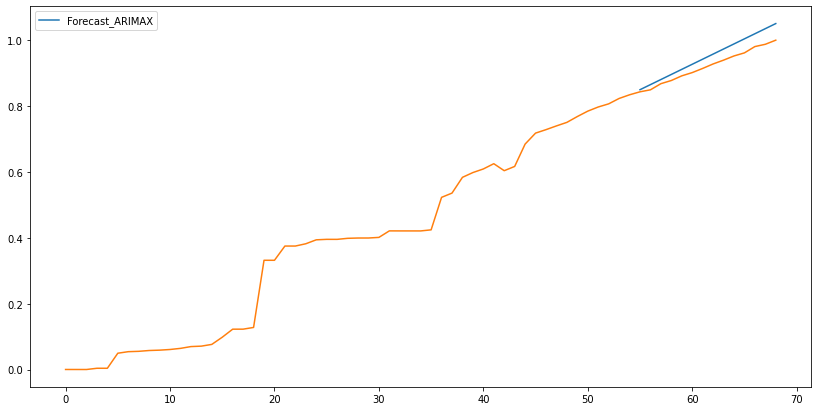

In [37]:
%matplotlib inline

scaler = get_scaler('minmax')
AHB_data_arr = scaler.fit_transform(AHB_data[0])
temp=pd.DataFrame(AHB_data_arr, columns=['AHB_1', '1', '2', '3', '4', '5', '6', '7', '8', 'y'])

df_train = temp[:55]
df_valid = temp[55:]
temp2 = [str(x) for x in province_AHB_list[0]]
temp2.pop(0)
model = arima.auto_arima(df_train['AHB_1'], exogenous=df_train[temp2], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train['AHB_1'], exogenous=df_train[temp2])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[temp2])
df_valid["Forecast_ARIMAX"] = forecast.values
df_valid[["Forecast_ARIMAX"]].plot(figsize=(14, 7))
temp['AHB_1'].plot()

print('MAE: ' + str(mean_absolute_error(df_valid['y'],df_valid['Forecast_ARIMAX'])))
print('MSE: ' + str(mean_squared_error(df_valid['y'],df_valid['Forecast_ARIMAX'])))
print('RMSE: ' + str(mean_squared_error(df_valid['y'],df_valid['Forecast_ARIMAX'],squared = False)))
print('MAPE: ' + str(mean_absolute_percentage_error(df_valid['y'],df_valid['Forecast_ARIMAX'])))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-207.018, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-214.582, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-212.778, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-212.756, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-205.255, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-210.909, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.077 seconds
MAE: 0.032158852582294895
MSE: 0.0012039713411639114
RMSE: 0.03469829017637485
MAPE: 0.03438592647394332


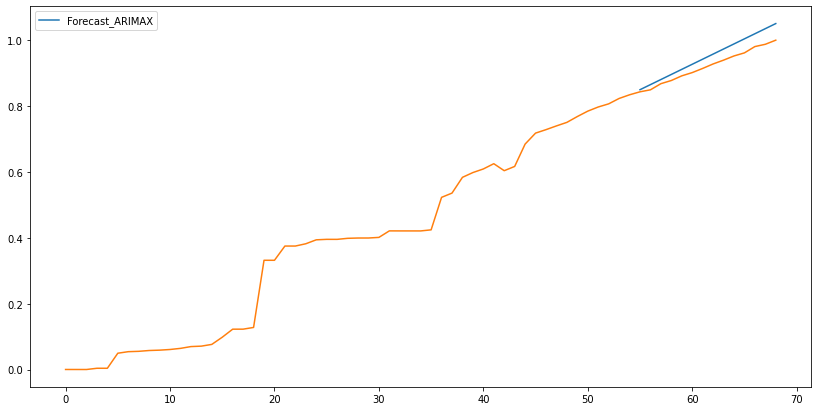

In [34]:
%matplotlib inline

scaler = get_scaler('minmax')
AHB_data_arr = scaler.fit_transform(AHB_data[0])
temp=pd.DataFrame(AHB_data_arr, columns=['AHB_1', '1', '2', '3', '4', '5', '6', '7', '8', 'y'])

df_train = temp[:55]
df_valid = temp[55:]
temp2 = [str(x) for x in province_AHB_list[0]]
temp2.pop(0)
model = arima.auto_arima(df_train['AHB_1'], exogenous=df_train['AHB_1'], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train['AHB_1'], exogenous=df_train['AHB_1'])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid['AHB_1'])
df_valid["Forecast_ARIMAX"] = forecast.values
df_valid[["Forecast_ARIMAX"]].plot(figsize=(14, 7))
temp['AHB_1'].plot()

print('MAE: ' + str(mean_absolute_error(df_valid['y'],df_valid['Forecast_ARIMAX'])))
print('MSE: ' + str(mean_squared_error(df_valid['y'],df_valid['Forecast_ARIMAX'])))
print('RMSE: ' + str(mean_squared_error(df_valid['y'],df_valid['Forecast_ARIMAX'],squared = False)))
print('MAPE: ' + str(mean_absolute_percentage_error(df_valid['y'],df_valid['Forecast_ARIMAX'])))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-207.018, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-214.582, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-212.778, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-212.756, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-205.255, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-210.909, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.607 seconds
MAE: 0.03075531781563852
MSE: 0.0011011503426684023
RMSE: 0.03318358544022033
MAPE: 0.03315370508356759
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-207.018, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-214.582, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-212.778, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-212.756, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-205.255, Time=0.02 sec
 ARIMA(

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-205.518, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-206.077, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-204.290, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-204.609, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-197.958, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-205.558, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.501 seconds
MAE: 0.048909966124059595
MSE: 0.002698644636107035
RMSE: 0.05194848059478771
MAPE: 0.05306363393615085
Performing stepwise search to minimize aic


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-197.643, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-190.869, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-188.906, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-189.093, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-185.641, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-199.607, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-201.554, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-199.613, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-193.084, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-198.714, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-190.516, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.377 seconds


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


MAE: 0.027890473030395508
MSE: 0.0008334299059333319
RMSE: 0.02886918609752156
MAPE: 0.03098800383934713
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-197.643, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-190.869, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-188.906, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-189.093, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-185.641, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-199.607, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-201.554, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-199.613, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-193.084, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-198.714, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-190.516, Time=0.09 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.378 seconds


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


MAE: 0.027890473030395508
MSE: 0.0008334299059333319
RMSE: 0.02886918609752156
MAPE: 0.03098800383934713


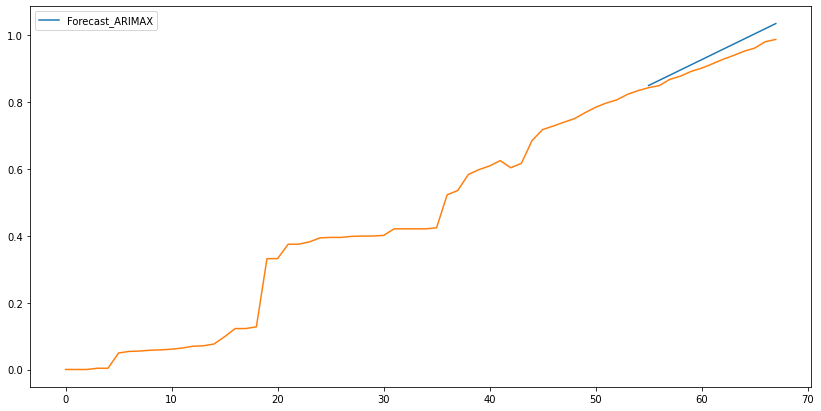

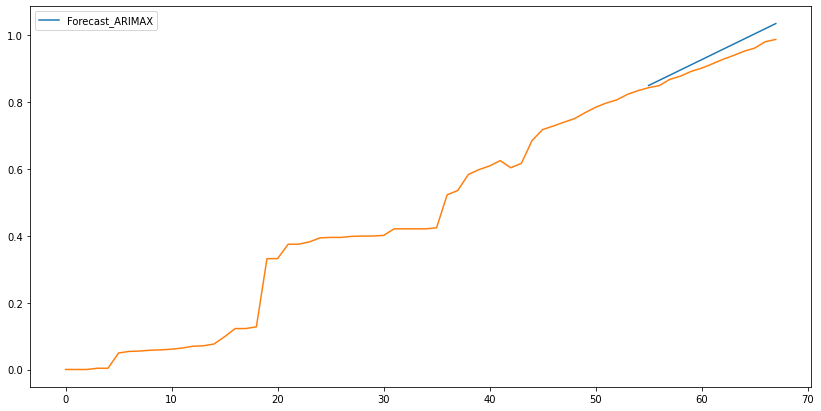

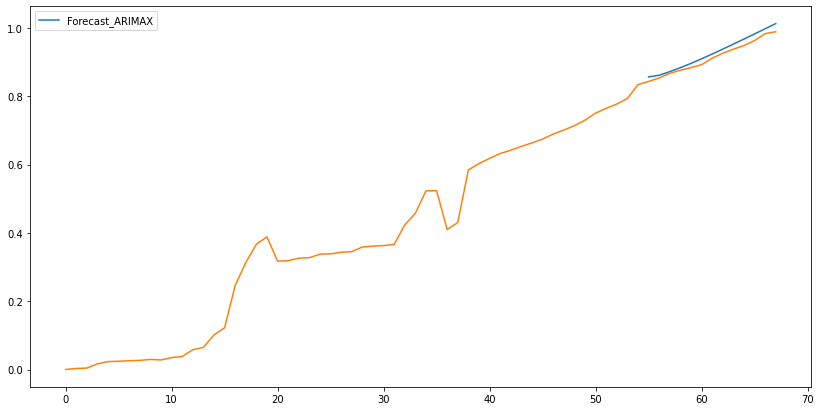

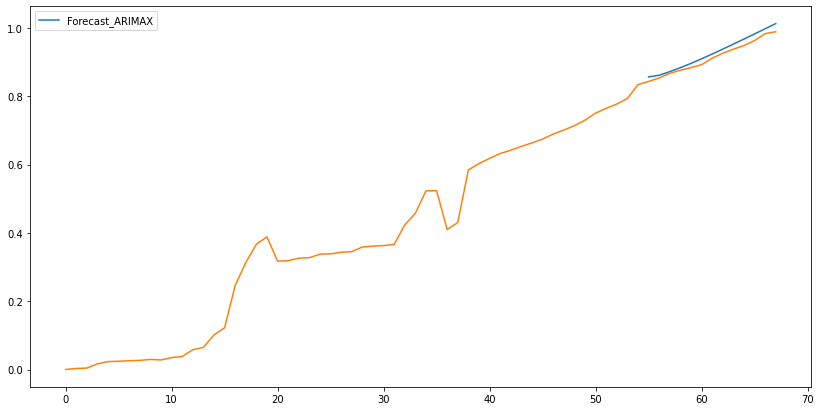

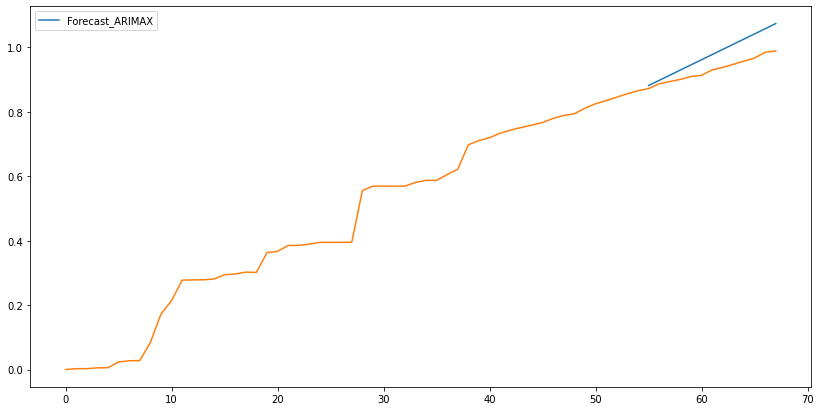

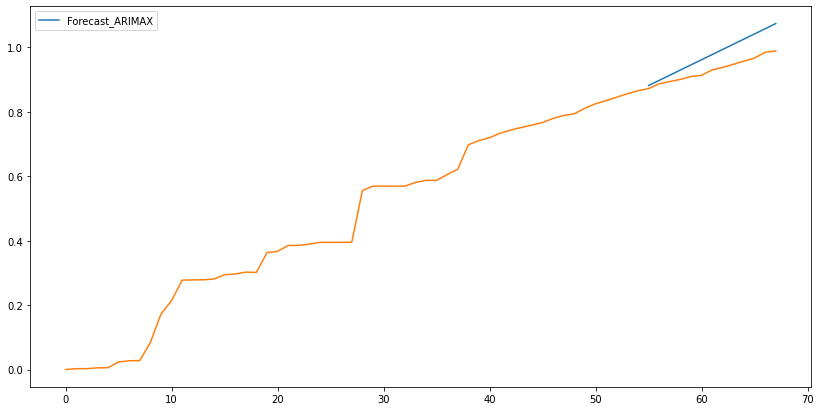

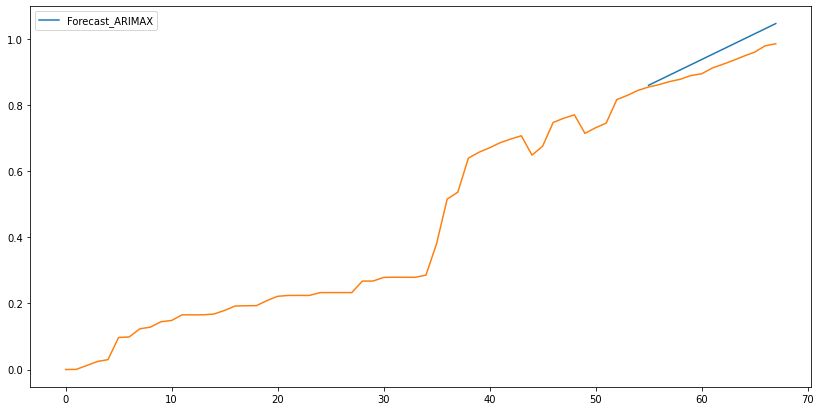

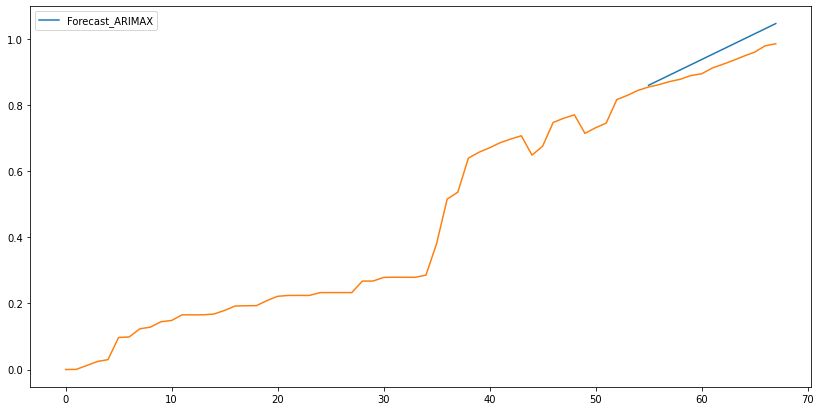

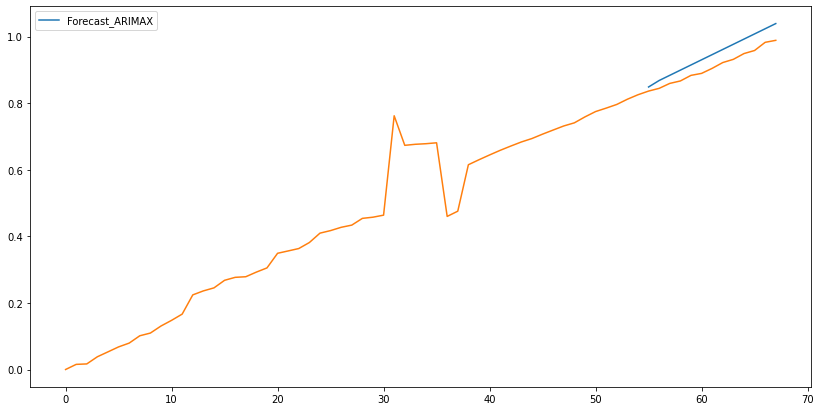

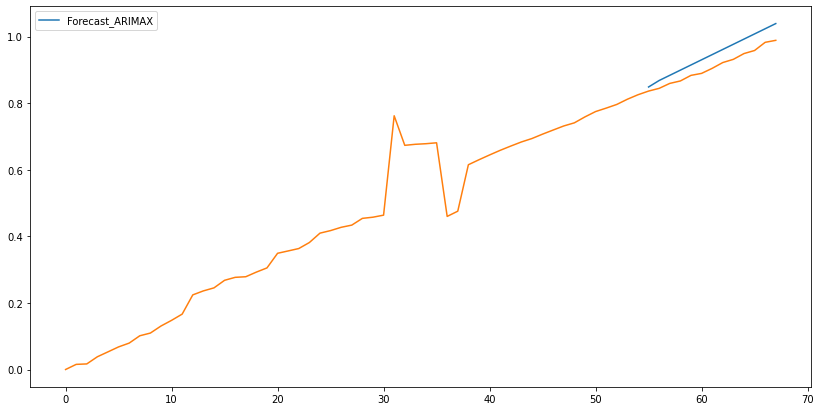

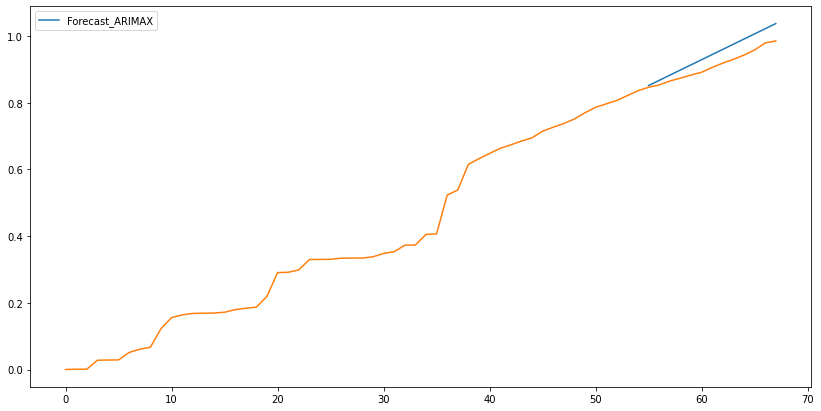

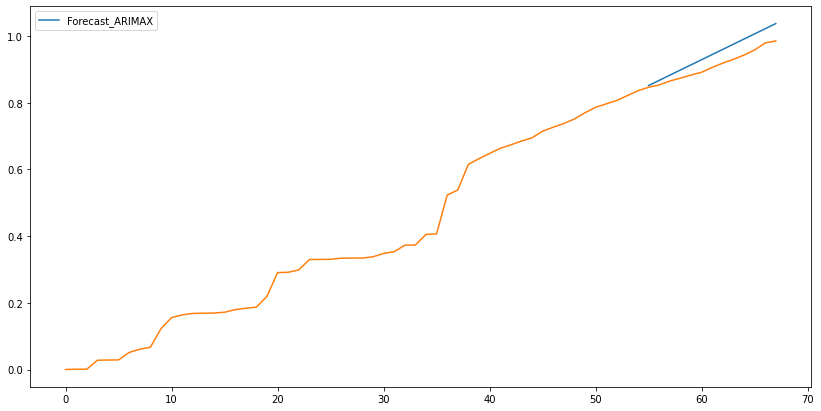

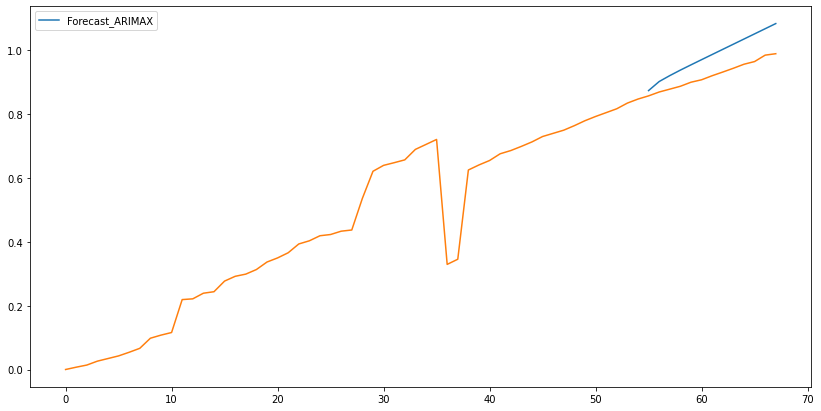

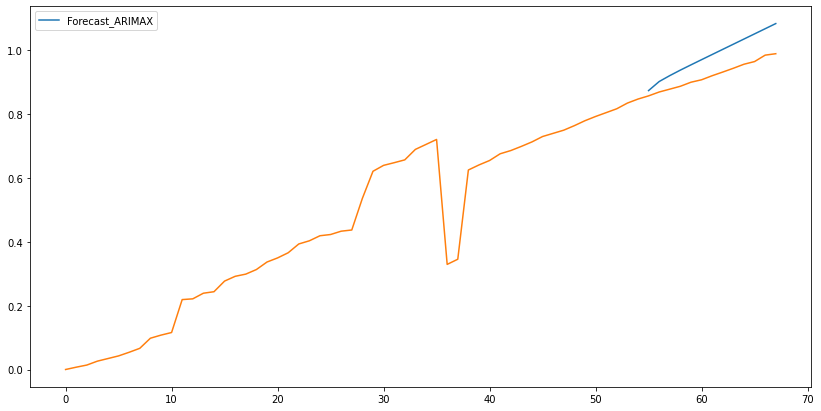

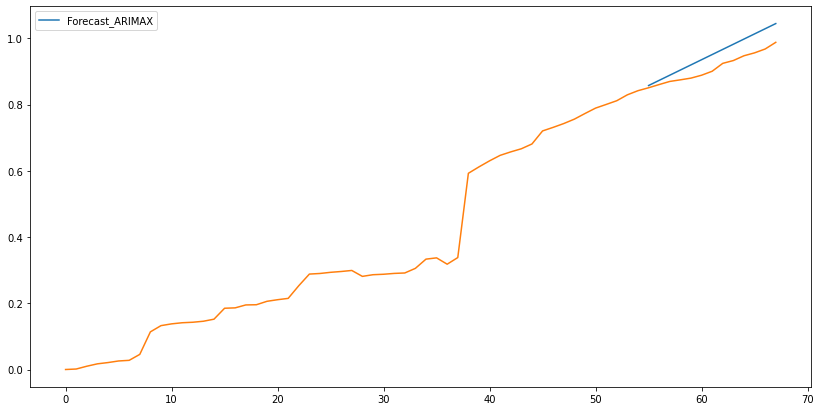

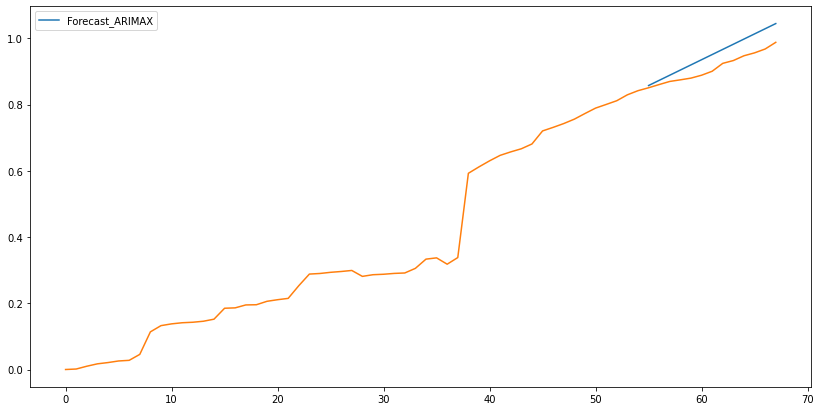

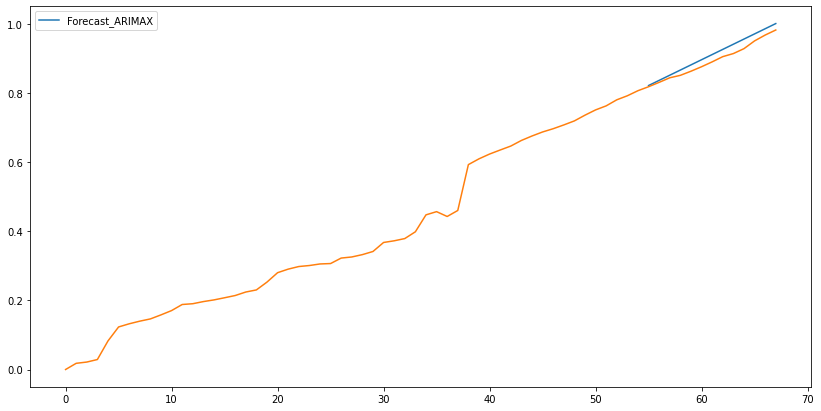

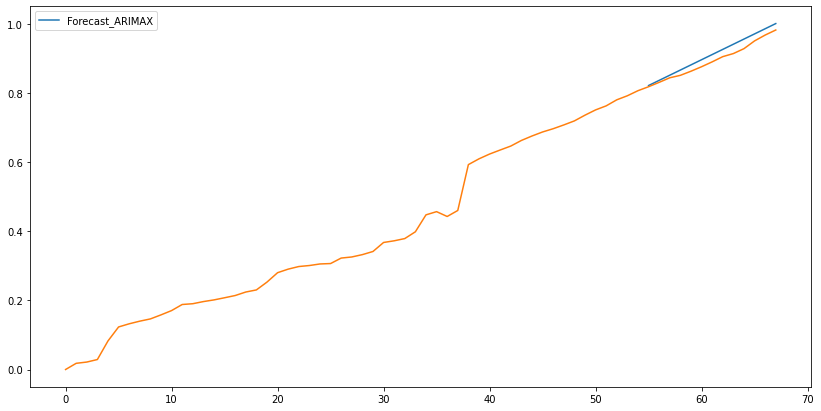

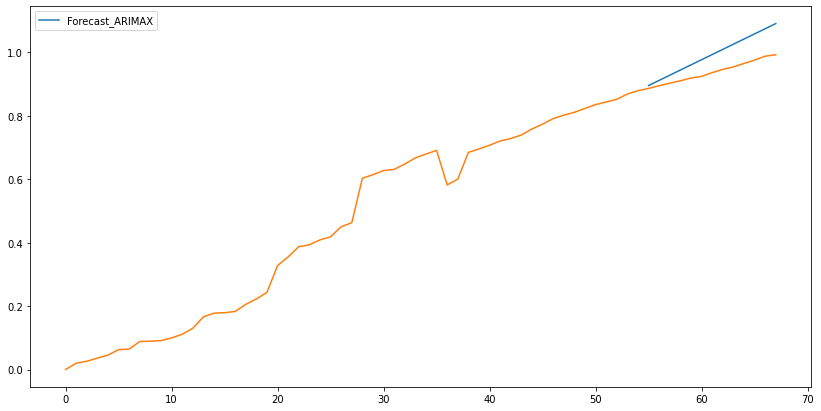

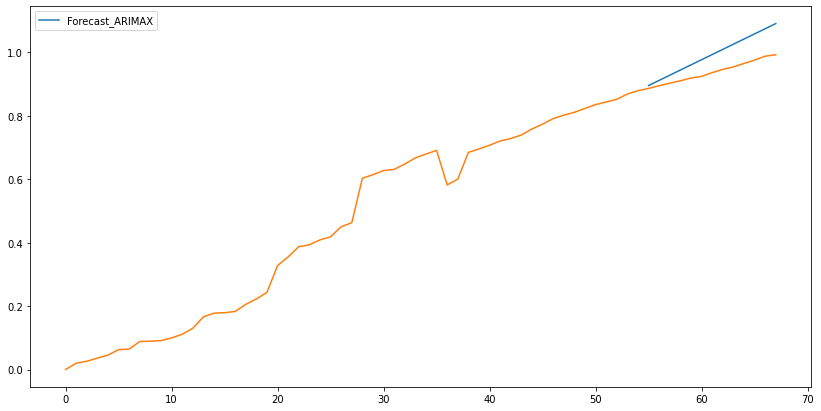

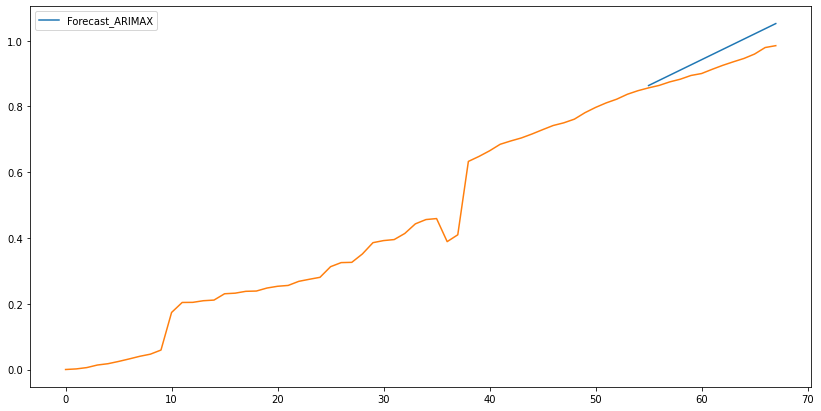

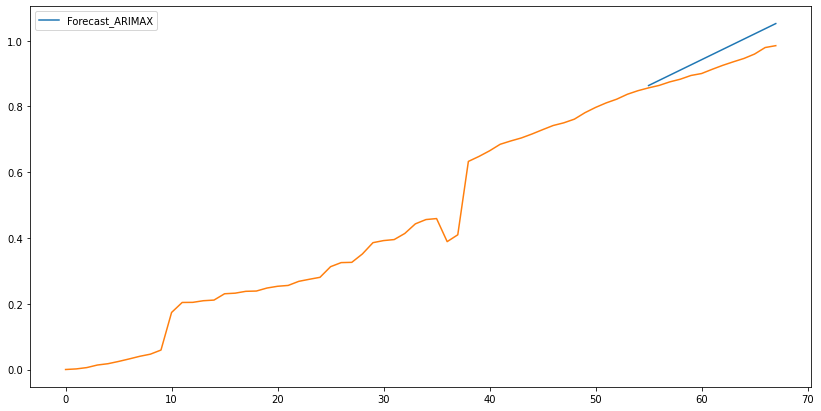

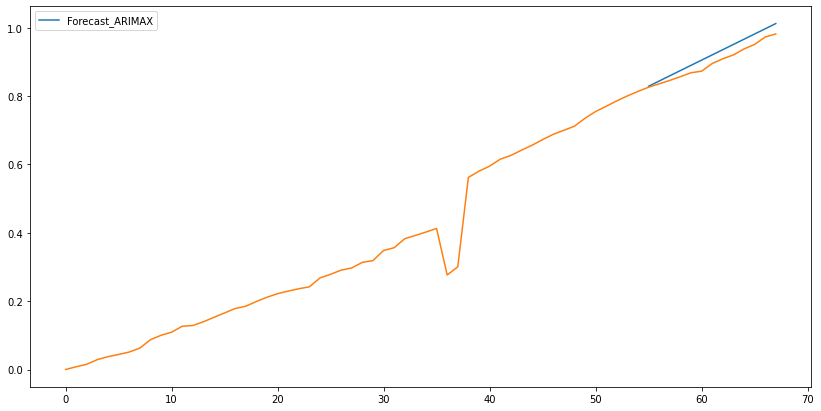

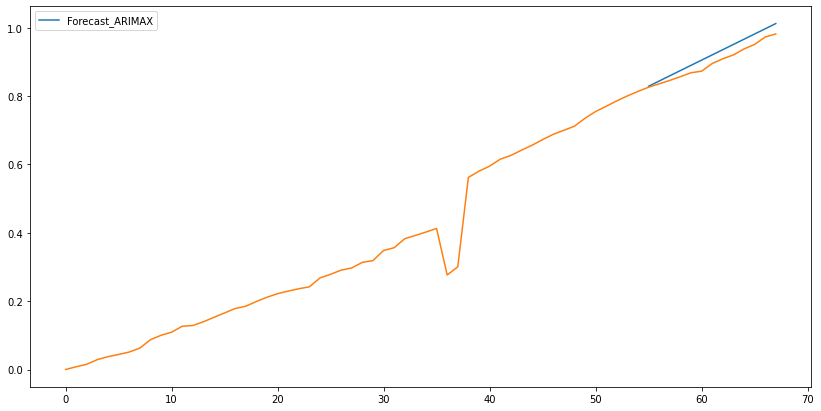

In [54]:
%matplotlib inline
performance_arima_json = []

for i in range(len(AHB_data)):
    scaler = get_scaler('minmax')
    AHB_data_arr = scaler.fit_transform(AHB_data[i])
    temp=pd.DataFrame(AHB_data_arr, columns=AHB_data[i].columns)
    temp = temp.drop(temp.tail(1).index)

    df_train = temp[:55]
    df_valid = temp[55:]
    temp2 = [str(x) for x in province_AHB_list[i]]
    temp2.pop(0)
    model = arima.auto_arima(df_train['AHB_'+str(i+1)], exogenous=df_train[temp2], trace=True, error_action="ignore", suppress_warnings=True)
    model.fit(df_train['AHB_'+str(i+1)], exogenous=df_train[temp2])

    forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[temp2])
    df_valid["Forecast_ARIMAX"] = forecast.values
    df_valid[["Forecast_ARIMAX"]].plot(figsize=(14, 7))
    temp['AHB_'+str(i+1)].plot()

    print('MAE: ' + str(mean_absolute_error(df_valid['y'],df_valid['Forecast_ARIMAX'])))
    print('MSE: ' + str(mean_squared_error(df_valid['y'],df_valid['Forecast_ARIMAX'])))
    print('RMSE: ' + str(mean_squared_error(df_valid['y'],df_valid['Forecast_ARIMAX'],squared = False)))
    print('MAPE: ' + str(mean_absolute_percentage_error(df_valid['y'],df_valid['Forecast_ARIMAX'])))

    performance_arima_json.append({'AHB_number': i+1, 'Uni_or_Multi': 'Multi', 'order' :model.get_params().get('order'), 'MAE': mean_absolute_error(df_valid['y'],df_valid['Forecast_ARIMAX']), 'MSE': mean_squared_error(df_valid['y'],df_valid['Forecast_ARIMAX']), 'RMSE': mean_squared_error(df_valid['y'],df_valid['Forecast_ARIMAX'],squared = False), 'MAPE': mean_absolute_percentage_error(df_valid['y'],df_valid['Forecast_ARIMAX'])})



    scaler = get_scaler('minmax')
    AHB_data_arr = scaler.fit_transform(AHB_data[i])
    temp=pd.DataFrame(AHB_data_arr, columns=AHB_data[i].columns)
    temp = temp.drop(temp.tail(1).index)

    df_train = temp[:55]
    df_valid = temp[55:]
    temp2 = [str(x) for x in province_AHB_list[i]]
    temp2.pop(0)
    model = arima.auto_arima(df_train['AHB_'+str(i+1)], exogenous=df_train['AHB_'+str(i+1)], trace=True, error_action="ignore", suppress_warnings=True)
    model.fit(df_train['AHB_'+str(i+1)], exogenous=df_train['AHB_'+str(i+1)])

    forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid['AHB_'+str(i+1)])
    df_valid["Forecast_ARIMAX"] = forecast.values
    df_valid[["Forecast_ARIMAX"]].plot(figsize=(14, 7))
    temp['AHB_'+str(i+1)].plot()

    print('MAE: ' + str(mean_absolute_error(df_valid['y'],df_valid['Forecast_ARIMAX'])))
    print('MSE: ' + str(mean_squared_error(df_valid['y'],df_valid['Forecast_ARIMAX'])))
    print('RMSE: ' + str(mean_squared_error(df_valid['y'],df_valid['Forecast_ARIMAX'],squared = False)))
    print('MAPE: ' + str(mean_absolute_percentage_error(df_valid['y'],df_valid['Forecast_ARIMAX'])))

    performance_arima_json.append({'AHB_number': i+1, 'Uni_or_Multi': 'Uni','order' :model.get_params().get('order'), 'MAE': mean_absolute_error(df_valid['y'],df_valid['Forecast_ARIMAX']), 'MSE': mean_squared_error(df_valid['y'],df_valid['Forecast_ARIMAX']), 'RMSE': mean_squared_error(df_valid['y'],df_valid['Forecast_ARIMAX'],squared = False), 'MAPE': mean_absolute_percentage_error(df_valid['y'],df_valid['Forecast_ARIMAX'])})


In [55]:
json.dump(performance_arima_json, open("performance_arima.json","w"))
df_json = pd.read_json('/content/performance_arima.json')
df_json.to_csv('/content/performance_arima.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='performance_arima.json' mode='w' encoding='UTF-8'>
  """Entry point for launching an IPython kernel.


In [56]:
df_json

,AHB_number,Uni_or_Multi,order,MAE,MSE,RMSE,MAPE
0,1,Multi,"[0, 1, 0]",0.030755,0.001101,0.033184,0.033154
1,1,Uni,"[0, 1, 0]",0.030755,0.001101,0.033184,0.033154
2,2,Multi,"[2, 1, 2]",0.021360,0.000487,0.022060,0.023419
3,2,Uni,"[2, 1, 2]",0.021360,0.000487,0.022060,0.023419
4,3,Multi,"[0, 1, 0]",0.048116,0.002901,0.053860,0.050838
5,3,Uni,"[0, 1, 0]",0.048116,0.002901,0.053860,0.050838
6,4,Multi,"[1, 1, 0]",0.041690,0.001975,0.044444,0.045012
7,4,Uni,"[1, 1, 0]",0.041690,0.001975,0.044444,0.045012
8,5,Multi,"[0, 1, 2]",0.047953,0.002404,0.049031,0.053021
9,5,Uni,"[0, 1, 2]",0.047953,0.002404,0.049031,0.053021


#ARIMAX Model by sktime

In [ ]:
sns.set(rc={'figure.figsize':(12,6)})

y = normalized_AHB_data[0]['AHB_1']
y.index = pd.to_datetime(y.index) 
forecaster = AutoARIMA(sp=1, seasonal=False, trend = True, information_criterion = 'bic')
cv = ExpandingWindowSplitter(step_length=5, fh=list(range(1, 6)), initial_window=10)
cv_df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="update", return_data=True)

plot_series(
    y, *[cv_df["y_pred"].iloc[x] for x in range(5)],
    markers=["o", *["."]*5],
    labels=["y_true"] + [f"cv: {x}" for x in range(5)]
);

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)
/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(0,0,0)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)
/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,0)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)
/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(0,0,1)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="igno

TypeError: ignored

In [ ]:
cv = ExpandingWindowSplitter(step_length=5, fh=list(range(1, 6)), initial_window=10)
list(cv.split_series(y))[0][0]

2016-10-01   -1.490884
2016-11-01   -1.490988
2016-12-01   -1.491092
2017-01-01   -1.479695
2017-02-01   -1.479764
2017-03-01   -1.340600
2017-04-01   -1.326353
2017-05-01   -1.323087
2017-06-01   -1.315547
2017-07-01   -1.312280
Name: AHB_1, dtype: float64

In [ ]:
cv_df

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,NaN,0.671149,NaN,10,NaN,"2016-10-01 -1.490884 2016-11-01 -1.490988 2016-12-01 -1.491092 2017-01-01 -1.479695 2017-02-01 -1.479764 2017-03-01 -1.340600 2017-04-01 -1.326353 2017-05-01 -1.323087 2017-06-01 -1.315547 2017-07-01 -1.312280 Name: AHB_1, dtype: float64","2017-08-01 -1.306165 2017-09-01 -1.295775 2017-10-01 -1.279270 2017-11-01 -1.275135 2017-12-01 -1.259082 Name: AHB_1, dtype: float64",NaN
1,NaN,0.544572,NaN,15,NaN,"2016-10-01 -1.490884 2016-11-01 -1.490988 2016-12-01 -1.491092 2017-01-01 -1.479695 2017-02-01 -1.479764 2017-03-01 -1.340600 2017-04-01 -1.326353 2017-05-01 -1.323087 2017-06-01 -1.315547 2017-07-01 -1.312280 2017-08-01 -1.306165 2017-09-01 -1.295775 2017-10-01 -1.279270 2017-11-01 -1.275135 2017-12-01 -1.259082 Name: AHB_1, dtype: float64","2018-01-01 -1.192748 2018-02-01 -1.118423 2018-03-01 -1.118215 2018-04-01 -1.102404 2018-05-01 -0.481567 Name: AHB_1, dtype: float64",NaN
2,NaN,0.338794,NaN,20,NaN,"2016-10-01 -1.490884 2016-11-01 -1.490988 2016-12-01 -1.491092 2017-01-01 -1.479695 2017-02-01 -1.479764 2017-03-01 -1.340600 2017-04-01 -1.326353 2017-05-01 -1.323087 2017-06-01 -1.315547 2017-07-01 -1.312280 2017-08-01 -1.306165 2017-09-01 -1.295775 2017-10-01 -1.279270 2017-11-01 -1.275135 2017-12-01 -1.259082 2018-01-01 -1.192748 2018-02-01 -1.118423 2018-03-01 -1.118215 2018-04-01 -1.102404 2018-05-01 -0.481567 Name: AHB_1, dtype: float64","2018-06-01 -0.481706 2018-07-01 -0.350012 2018-08-01 -0.350047 2018-09-01 -0.328955 2018-10-01 -0.292539 Name: AHB_1, dtype: float64",NaN
3,NaN,0.365305,NaN,25,NaN,"2016-10-01 -1.490884 2016-11-01 -1.490988 2016-12-01 -1.491092 2017-01-01 -1.479695 2017-02-01 -1.479764 2017-03-01 -1.340600 2017-04-01 -1.326353 2017-05-01 -1.323087 2017-06-01 -1.315547 2017-07-01 -1.312280 2017-08-01 -1.306165 2017-09-01 -1.295775 2017-10-01 -1.279270 2017-11-01 -1.275135 2017-12-01 -1.259082 2018-01-01 -1.192748 2018-02-01 -1.118423 2018-03-01 -1.118215 2018-04-01 -1.102404 2018-05-01 -0.481567 2018-06-01 -0.481706 2018-07-01 -0.350012 2018-08-01 -0.350047 2018-09-01 -0.328955 2018-10-01 -0.292539 Name: AHB_1, dtype: f...","2018-11-01 -0.288092 2018-12-01 -0.288300 2019-01-01 -0.278675 2019-02-01 -0.275895 2019-03-01 -0.275756 Name: AHB_1, dtype: float64",NaN
4,NaN,0.293562,NaN,30,NaN,2016-10-01 -1.490884 2016-11-01 -1.490988 2016-12-01 -1.491092 2017-01-01 -1.479695 2017-02-01 -1.479764 2017-03-01 -1.340600 2017-04-01 -1.326353 2017-05-01 -1.323087 2017-06-01 -1.315547 2017-07-01 -1.312280 2017-08-01 -1.306165 2017-09-01 -1.295775 2017-10-01 -1.279270 2017-11-01 -1.275135 2017-12-01 -1.259082 2018-01-01 -1.192748 2018-02-01 -1.118423 2018-03-01 -1.118215 2018-04-01 -1.102404 2018-05-01 -0.481567 2018-06-01 -0.481706 2018-07-01 -0.350012 2018-08-01 -0.350047 2018-09-01 -0.328955 2018-10-01 -0.292539 2018-11-01 -0.28809...,"2019-04-01 -0.270092 2019-05-01 -0.209909 2019-06-01 -0.210187 2019-07-01 -0.210257 2019-08-01 -0.210326 Name: AHB_1, dtype: float64",NaN
5,NaN,0.300992,NaN,35,NaN,2016-10-01 -1.490884 2016-11-01 -1.490988 2016-12-01 -1.491092 2017-01-01 -1.479695 2017-02-01 -1.479764 2017-03-01 -1.340600 2017-04-01 -1.326353 2017-05-01 -1.323087 2017-06-01 -1.315547 2017-07-01 -1.312280 2017-08-01 -1.306165 2017-09-01 -1.295775 2017-10-01 -1.279270 2017-11-01 -1.275135 2017-12-01 -1.259082 2018-01-01 -1.192748 2018-02-01 -1.118423 2018-03-01 -1.118215 2018-04-01 -1.102404 2018-05-01 -0.481567 2018-06-01 -0.481706 2018-07-01 -0.350012 2018-08-01 -0.350047 2018-09-01 -0.328955 2018-10-01 -0.292539 2018-11-01 -0.28809...,"2019-09-01 -0.200354 2019-10-01 0.100005 2019-11-01 0.139340 2019-12-01 0.285002 2020-01-01 0.329201 Name: AHB_1, dtype: float64",NaN
6,NaN,0.439653,NaN,40,NaN,2016-10-01 -1.490884 2016-11-01 -1.490988 2016-12-01 -1.491092 2017-01-01 -1.479695 2017-02-01 -1.479764 2017-03-01 -1.340600 2017-04-01 -1.326353 2017-05-01 -1.323087 2017-06-01 -1.315547 2017-07-01 -1.312